## Object Detection On Command
---

### Overview

This project will explore YOLO algorithm with Resnet50 using transfer learning, a method to use a pre-trained neural network and adapt the model to perform different tasks with different dataset, and design a model that is compatible with real-time video processing. PASCAL VOC (Visual Object Classes) 2012 dataset  will be in use of training models, and the model will be tested on real-time video data collected from webcams.


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Understand PASCAL VOC 2012 Data
* [Step 1](#step1): Data Pre-processing
* [Step 2](#step2): Model Architecture
* [Step 3](#step3): Loss Function
* [Step 4](#step4): -
* [Step 5](#step5): -
* [Step 6](#step6): -
* [Step 7](#step7): -
* [Step 8](#step8): -
---
<a id='step0'></a>
## Step 0: Understand PASCAL VOC 2012 Data

### Combining annotation files into one CSV file

PASCAL VOC 2012 dataset has corresponding .xml file with annotation for each image jpg file.
Due to its complexity, we need to combine all these .xml files into one single csv file via panda modules.

First, let's sort all these xml files into one table.

In [1]:
anno_dir = "/home/ubuntu/VOCdevkit/VOC2012/Annotations/"
img_dir  = "/home/ubuntu/VOCdevkit/VOC2012/JPEGImages/"

In [2]:
import os 
import numpy as np
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd 

def extracting_xml(tree):
    objN = 0
    row  = OrderedDict()
    for lines in tree.iter():
        
        if lines.tag == "size":
            for elem in lines:
                row[elem.tag] = int(elem.text)
                
        if lines.tag == "object":
            for elem in lines:
                if elem.tag == "name":
                    row["bbx_{}_{}".format(objN,elem.tag)] = str(elem.text)              
                if elem.tag == "bndbox":
                    for i in elem:
                        row["bbx_{}_{}".format(objN,i.tag)] = float(i.text)
                    objN += 1
    row["objN"] = objN
    return(row)

df_anno = []
for filename in os.listdir(anno_dir):  
    if not filename.startswith('.'): ## avoid hidden folders and files
        tree = ET.parse(os.path.join(anno_dir,filename))
        row = extracting_xml(tree)
        row["fileID"] = filename.split(".")[0]
        df_anno.append(row)
df_anno = pd.DataFrame(df_anno)

maxobjN = np.max(df_anno["objN"])

df_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,500,375,3,person,11.0,121.0,161.0,375.0,person,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,336,3,person,212.0,101.0,351.0,336.0,person,322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500,386,3,dog,170.0,138.0,339.0,271.0,chair,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,373,500,3,bird,130.0,132.0,258.0,320.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,329,500,3,person,101.0,175.0,249.0,325.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---------------------------------
Save the table as a csv file.

In [3]:
# location to save df_anno.csv
csv_location = "/home/ubuntu/VOCdevkit/VOC2012"
df_anno.to_csv(os.path.join(csv_location,"df_anno.csv"),index=False)

### Setting the training - validation set

Training - Validation dataset is provided by PASCAL VOC 2012 datset. <br>
We're just going to read in the list of image file names.

Since each class has different number of data, the number of images in training and validation dataset does not represent the ratio of training - validation data.

Number of training images: 5717
Number of valid images: 5824
Number of trainval images: 11541
 
Example image:
height: 442  width: 500  color: 3


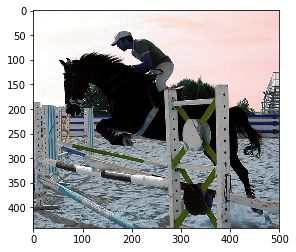

In [4]:
import cv2
import matplotlib.pyplot as plt

train_image_dir = "/home/ubuntu/VOCdevkit/VOC2012/ImageSets/Main/train.txt"
val_image_dir = "/home/ubuntu/VOCdevkit/VOC2012/ImageSets/Main/val.txt"
trainval_image_dir = "/home/ubuntu/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt"
train_image_fnm = open(train_image_dir,"r").read().split('\n')
train_image_fnm.pop() #somehow, the last element is empty
val_image_fnm = open(val_image_dir,"r").read().split('\n')
trainval_image_fnm = open(trainval_image_dir,"r").read().split('\n')
print("Number of training images:", len(train_image_fnm))
print("Number of valid images:", len(val_image_fnm))
print("Number of trainval images:", len(trainval_image_fnm))
print(" ")
print("Example image:")

img=cv2.imread(img_dir + train_image_fnm[0]+".jpg")
h, w, c = img.shape
print ("height:",h," width:", w," color:", c)
plt.imshow(img)
plt.show()

### Achieving test data

In order to receive test data for PASCAL VOC 2012 Challenge, you need to go to [this site](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#testdata)
<br>

Here, you have to register and download the test data in a .tar form.
After un-tarring this file (refer to ReadMe.md), place the folder in your VOC Devkit folder.

---
<a id='step1'></a>
## Step 1: Data Pre-processing

### Rescaling images to 416 * 416

CNN reads in pre-specified shape of images. For each image input, no matter what size they portrait, they will be encoded into (416, 416, 3). Meaning, they will be input as a form of 416 * 416 pixels with color. Parameters xmin, xmax, ymin, and ymax will be adjusted accordingly.

height: 416  width: 416  color: 3


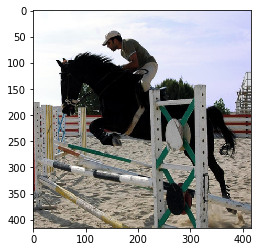

In [5]:
def rescale_img(new_h, new_w, path):
    image=cv2.imread(path)
    image=cv2.resize(image,(new_h, new_w))
    image = image[:,:,::-1] #re-ordering rgb
    image = image/255 #normalizing
    
    return image

new_h = 416 #new height of the resized image
new_w = 416 #new width of the resized image


path = img_dir + train_image_fnm[0]+".jpg"
image = rescale_img(new_h, new_w, path)


h, w, c = image.shape
print ("height:",h," width:", w," color:", c)
plt.imshow(image)
plt.show()

### Creating another dataframe with rescaled images

In [6]:
rescaled_anno = df_anno.copy()
rescaled_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,500,375,3,person,11.0,121.0,161.0,375.0,person,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,336,3,person,212.0,101.0,351.0,336.0,person,322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500,386,3,dog,170.0,138.0,339.0,271.0,chair,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,373,500,3,bird,130.0,132.0,258.0,320.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,329,500,3,person,101.0,175.0,249.0,325.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adjust the bounding boxes accordingly
<br>
Not only changing the width and height of images, we also have to change the bounding boxes of images.<br><br>
<b>(xmin or xmax) / (original width) = (new xmin or xmax) / (new width = 416)<br>
(ymin or ymax) / (original height) = (new ymin or ymax) / (new height = 416)</b>

In [7]:
for N in range(0,maxobjN):    
    for cr in ['xmin', 'xmax']:
        self = rescaled_anno["bbx_{}_{}".format(N,cr)].copy()
        rescaled_anno["bbx_{}_{}".format(N,cr)] = self * new_w / df_anno["width"]
    for cr in ['ymin', 'ymax']:
        self = rescaled_anno["bbx_{}_{}".format(N,cr)].copy()
        rescaled_anno["bbx_{}_{}".format(N,cr)] = self * new_h / df_anno["height"]

rescaled_anno["width"] = new_w
rescaled_anno["height"] = new_h
rescaled_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,416,416,3,person,9.152000,134.229333,133.952000,416.000000,person,31.616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,416,416,3,person,176.384000,125.047619,292.032000,416.000000,person,267.904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,416,416,3,dog,141.440000,148.725389,282.048000,292.062176,chair,0.832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,416,416,3,bird,144.986595,109.824000,287.742627,266.240000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,416,416,3,person,127.708207,145.600000,314.844985,270.400000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visualization of rescaled images

Here, I will show how bounding boxes have resized and relocated according to newly scaled images.

In [8]:
import imageio
def plt_rectangle(plt,label,x1,y1,x2,y2):
    '''
    == Input ==
    
    plt   : matplotlib.pyplot object
    label : string containing the object class name
    x1    : top left corner x coordinate
    y1    : top left corner y coordinate
    x2    : bottom right corner x coordinate
    y2    : bottom right corner y coordinate
    '''
    linewidth = 1
    color = "yellow"
    plt.text(x1,y1,label,fontsize=10,backgroundcolor="magenta")
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color)
    

    
    
plt.imshow(image) # plot image
df = rescaled_anno.loc[rescaled_anno['fileID']==train_image_fnm[0]] 
row_num = int(df.index.values)
print(row_num)
df.head()


870


,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,bbx_1_name,bbx_1_xmin,...,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
870,416,416,3,horse,44.096,81.882353,391.872,395.294118,person,131.456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


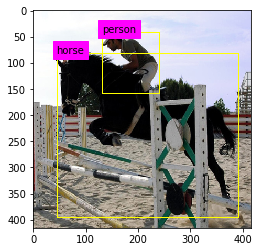

In [9]:
plt.imshow(image) # plot image

# for each object in the image, plot the bounding box
for iplot in range(df.at[row_num,"objN"]):
    plt_rectangle(plt,
                  label = df.at[row_num,"bbx_{}_name".format(iplot)],
                  x1=df.at[row_num,"bbx_{}_xmin".format(iplot)],
                  y1=df.at[row_num,"bbx_{}_ymin".format(iplot)],
                  x2=df.at[row_num,"bbx_{}_xmax".format(iplot)],
                  y2=df.at[row_num,"bbx_{}_ymax".format(iplot)])
plt.show() ## show the plot

### Bounding Box Encoding

<br>
So far, we have been plotting out bounding boxes based on the coordinates provided by the PASCAL VOC 2012 dev kit, which is formatted as below: <br><br>
<b>{bbx_n_name,bbx_n_xmin,bbx_n_ymin,bbx_n_xmax,bbx_n_ymax}</b>

However, the algorithm we will use require different format of bounding box coordinates which can be described as below:
<b>{bbx_n_name,bbx_n_center_x,bbx_n_center_y,bbx_n_center_w,bbx_n_center_h}</b><br><br>
The transformation will take place as explained in the image below (from [Yumi's blog](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html#Output-encoding-2:)):<br>
</html>
<img src="images/boundingbox_datatransform.png" alt="Drawing" style="width: 400px;"/>
</html>


Let's rename the coulmn names first!

In [10]:
transformed_anno = rescaled_anno.copy()
#old column names
old_col_nms_xmin=[]
old_col_nms_ymin=[]
old_col_nms_xmax=[]
old_col_nms_ymax=[]
#new column names
new_col_nms_xmin=[]
new_col_nms_ymin=[]
new_col_nms_xmax=[]
new_col_nms_ymax=[]

for i in range(maxobjN):
    old_col_nms_xmin.append("bbx_{}_xmin".format(i))
    old_col_nms_ymin.append("bbx_{}_ymin".format(i))
    old_col_nms_xmax.append("bbx_{}_xmax".format(i))
    old_col_nms_ymax.append("bbx_{}_ymax".format(i))
    new_col_nms_xmin.append("bbx_{}_center_x".format(i))
    new_col_nms_ymin.append("bbx_{}_center_y".format(i))
    new_col_nms_xmax.append("bbx_{}_center_w".format(i))
    new_col_nms_ymax.append("bbx_{}_center_h".format(i))

transformed_anno.rename(columns=dict(zip(old_col_nms_xmin, new_col_nms_xmin)), inplace=True)
transformed_anno.rename(columns=dict(zip(old_col_nms_ymin, new_col_nms_ymin)), inplace=True)
transformed_anno.rename(columns=dict(zip(old_col_nms_xmax, new_col_nms_xmax)), inplace=True)
transformed_anno.rename(columns=dict(zip(old_col_nms_ymax, new_col_nms_ymax)), inplace=True)


transformed_anno.head()

,width,height,depth,bbx_0_name,bbx_0_center_x,bbx_0_center_y,bbx_0_center_w,bbx_0_center_h,bbx_1_name,bbx_1_center_x,...,bbx_54_name,bbx_54_center_x,bbx_54_center_y,bbx_54_center_w,bbx_54_center_h,bbx_55_name,bbx_55_center_x,bbx_55_center_y,bbx_55_center_w,bbx_55_center_h
0,416,416,3,person,9.152000,134.229333,133.952000,416.000000,person,31.616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,416,416,3,person,176.384000,125.047619,292.032000,416.000000,person,267.904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,416,416,3,dog,141.440000,148.725389,282.048000,292.062176,chair,0.832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,416,416,3,bird,144.986595,109.824000,287.742627,266.240000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,416,416,3,person,127.708207,145.600000,314.844985,270.400000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our algorithm will divide each image into grids and process image classification and localization for each grid cell.<br>
For this, we have to rescale the coordinates assuming the side length of each grid cell being 1.

In [11]:
grid_w = 13
grid_h = 13

for i in range(maxobjN):
    #center_x = 0.5*(xmin+xmax), center_y = 0.5*(ymin+ymax)
    #center_w = xmax - xmin, center_h = ymax - ymin
    center_x=0.5*(rescaled_anno["bbx_{}_xmin".format(i)]+rescaled_anno["bbx_{}_xmax".format(i)])
    center_y=0.5*(rescaled_anno["bbx_{}_ymin".format(i)]+rescaled_anno["bbx_{}_ymax".format(i)])
    center_w=rescaled_anno["bbx_{}_xmax".format(i)]-rescaled_anno["bbx_{}_xmin".format(i)]
    center_h=rescaled_anno["bbx_{}_ymax".format(i)]-rescaled_anno["bbx_{}_ymin".format(i)]
    
    #Rescaling the coordinates assuming the side length of each grid cell being 1.
    transformed_anno["bbx_{}_center_x".format(i)]=center_x/(float(new_w))*grid_w
    transformed_anno["bbx_{}_center_y".format(i)]=center_y/(float(new_h))*grid_h
    transformed_anno["bbx_{}_center_w".format(i)]=center_w/(float(new_w))*grid_w
    transformed_anno["bbx_{}_center_h".format(i)]=center_h/(float(new_h))*grid_h

transformed_anno.head()

,width,height,depth,bbx_0_name,bbx_0_center_x,bbx_0_center_y,bbx_0_center_w,bbx_0_center_h,bbx_1_name,bbx_1_center_x,...,bbx_54_name,bbx_54_center_x,bbx_54_center_y,bbx_54_center_w,bbx_54_center_h,bbx_55_name,bbx_55_center_x,bbx_55_center_y,bbx_55_center_w,bbx_55_center_h
0,416,416,3,person,2.236000,8.597333,3.900000,8.805333,person,3.003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,416,416,3,person,7.319000,8.453869,3.614000,9.092262,person,9.880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,416,416,3,dog,6.617000,6.887306,4.394000,4.479275,chair,2.340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,416,416,3,bird,6.761394,5.876000,4.461126,4.888000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,416,416,3,person,6.914894,6.500000,5.848024,3.900000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preparing CSV files for training and validation dataset

In order to train our model, we will prepare two different csv files; one contains data of training images with rescaled annotations and the other contains those of validation images also with rescaled annotations.
These two data will be extracted from the original csv file that contains information for all the images in our datset by matching the fileID.

In [12]:
train_df=transformed_anno.loc[transformed_anno['fileID'].isin(train_image_fnm)]
print("The number of images in our training dataframe: ",train_df.shape[0])
print("The number of file names from train.txt: ", len(train_image_fnm))
val_df=transformed_anno.loc[transformed_anno['fileID'].isin(val_image_fnm)]
print("The number of images in our validation dataframe: ",val_df.shape[0])
print("The number of file names from val.txt: ", len(val_image_fnm))


The number of images in our training dataframe:  5717
The number of file names from train.txt:  5717
The number of images in our validation dataframe:  5823
The number of file names from val.txt:  5824


Let's save those dataframes into csv files.

In [13]:
# location to save df_anno.csv
csv_location = "/home/ubuntu/VOCdevkit/VOC2012"
train_df.to_csv(os.path.join(csv_location,"train_df.csv"),index=False)
val_df.to_csv(os.path.join(csv_location,"val_df.csv"),index=False)

---
<a id='step2'></a>
## Step 2: Batch Generator


This batch generator is fairly a simple model. 
It shuffles the list of images from the train_df dataframe and produces output: x_batch and y_batch.<br><br>
x_batch = (batch_size, rescaled_image_height = 416, rescaled_image_width = 416, channel =3)<br>
y_batch = (batch_size, grid_height = 13, grid_width =13, 4 + 1 + Number of Classes)<br><br>

x_batch is composed of rescaled images.<br>
y_batch contains information about <br>
* Where the boxes are
* Existence of an object
* Classification of the object

y_batch(,,,0:4)       =  (center_x, center_y, center_w, center_h)<br>
y_batch(,,,4)         =  1 if (an object exists), 0 else <br>
y_batch(,,,5+iClass)  =  kinda like one-hot encoding with classes. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;i.g. if there is an aeroplane, aeroplane being the first class among the list, y_batch(,,,5+0) will be 1

In [14]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [107]:
from keras.utils import Sequence

class BatchGenerator(Sequence):
    def __init__(self, df, batch_size, grid_h, grid_w, LABELS, shuffle=True):
        self.batch_size = batch_size
        self.LABELS = LABELS
        self.CLASS = len(self.LABELS)
        self.grid_h = grid_h
        self.grid_w = grid_w
        self.df = df.copy()
        self.shuffle = shuffle
        if self.shuffle: 
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return int(np.ceil(float(self.df.shape[0])/self.batch_size))  
    
    def __getitem__(self, idx):
        
        l_bound = idx*self.batch_size
        r_bound = (idx+1)*self.batch_size

        if r_bound > self.df.shape[0]:
            r_bound = self.df.shape[0]
            l_bound = r_bound - self.batch_size
        
        ##initiate the instance for the output batch
        instance_cnt = 0
        
        ## empty storage space
        x_batch = np.zeros((self.batch_size, self.df["height"][0], self.df["width"][0], 3)) # input images
        #b_batch = np.zeros((self.batch_size, 1     , 1   , 4))   # bounding boxes
        y_batch = np.zeros((self.batch_size, self.grid_h,  self.grid_w , 4+1+self.CLASS)) # network output
        
        # ** 4 + 1 + self.CLASS **
        # * 4 => center_x, center_y, center_w, center_h of bounding boxes
        # * 1 = > either there is an object or not 
        # * CLASS => one hot encoding for class labels
        

        for index, row in self.df.loc[l_bound:r_bound-1].iterrows():  
            
            ##each object's bounding box index, reset every row
            box_index = 0
            print ("First Loop= index:", index)
            print("Second Loop = objN: ", row["objN"] )
            for obj in range(row["objN"]):
                
                center_x = row["bbx_{}_center_x".format(obj)]
                center_y = row["bbx_{}_center_y".format(obj)]
                center_w = row["bbx_{}_center_w".format(obj)]
                center_h = row["bbx_{}_center_h".format(obj)]
                
                ##At which grid is the object located?
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
                #What is the object? - kinda like one-hot encoding
                obj_idx  = self.LABELS.index(row["bbx_{}_name".format(obj)])
                
                
                ##Output of the generator - y_batch
                box = [center_x, center_y, center_w, center_h]
                y_batch[instance_cnt, grid_y, grid_x, 0:4] = box 
                y_batch[instance_cnt, grid_y, grid_x, 4  ] = 1. # ground truth confidence = 1
                y_batch[instance_cnt, grid_y, grid_x, 5+obj_idx] = 1 # class probability of the object
                
                ##Another output for bounding boxes from the generator - b_batch
                #b_batch[instance_cnt, 0, 0, box_index] = box
                box_index += 1
                print("obj =",obj) 
            ## Which image are these all about? - xbatch
            img_path = "/home/ubuntu/VOCdevkit/VOC2012/JPEGImages/"+row["fileID"]+".jpg"
            x_batch[instance_cnt] = rescale_img(self.df["height"][0], self.df["width"][0], img_path)
            ## increase instance counter
            
            print("instance_cnt: ",instance_cnt)
            print("")
            instance_cnt += 1
        #return [x_batch, b_batch], y_batch
        return x_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            self.df = self.df.sample(frac=1).reset_index(drop=True)

Below is a debugging process of this generator with an index of 3.

In [108]:
train_batch_generator = BatchGenerator(train_df, batch_size =16, grid_h=grid_h, grid_w=grid_w, LABELS=LABELS, shuffle=True)

#[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)
x_batch,y_batch = train_batch_generator.__getitem__(idx=3)

First Loop= index: 48
Second Loop = objN:  1
obj = 0
instance_cnt:  0

First Loop= index: 49
Second Loop = objN:  6
obj = 0
obj = 1
obj = 2
obj = 3
obj = 4
obj = 5
instance_cnt:  1

First Loop= index: 50
Second Loop = objN:  2
obj = 0
obj = 1
instance_cnt:  2

First Loop= index: 51
Second Loop = objN:  7
obj = 0
obj = 1
obj = 2
obj = 3
obj = 4
obj = 5
obj = 6
instance_cnt:  3

First Loop= index: 52
Second Loop = objN:  1
obj = 0
instance_cnt:  4

First Loop= index: 53
Second Loop = objN:  2
obj = 0
obj = 1
instance_cnt:  5

First Loop= index: 54
Second Loop = objN:  1
obj = 0
instance_cnt:  6

First Loop= index: 55
Second Loop = objN:  3
obj = 0
obj = 1
obj = 2
instance_cnt:  7

First Loop= index: 56
Second Loop = objN:  3
obj = 0
obj = 1
obj = 2
instance_cnt:  8

First Loop= index: 57
Second Loop = objN:  8
obj = 0
obj = 1
obj = 2
obj = 3
obj = 4
obj = 5
obj = 6
obj = 7
instance_cnt:  9

First Loop= index: 58
Second Loop = objN:  2
obj = 0
obj = 1
instance_cnt:  10

First Loop= index:

In [121]:
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: (16, 416, 416, 3)
y_batch shape: (16, 13, 13, 25)


---
<a id='step3'></a>
## Step 3: Model Architecture

### Base Model : Resnet50

In [120]:
from keras.applications import ResNet50
from keras.layers import Input
input_image = Input(shape=x_batch.shape[1:],name="input_image")
#true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4),name="input_hack")
base_model= ResNet50(include_top=False,weights='imagenet',input_shape= x_batch.shape[1:])
base_model.trainable = False

base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  9472        input_2[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 208, 208, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### Transfer Learning

In [114]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, Dropout
from backend import ConvBatchLReLu

#Code by George Seif: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model


FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=4+1+len(LABELS))
finetune_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 208, 208, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### Initialize Weights

---
<a id='step3'></a>
## Step 3: Loss Function

### Calculating Intersection Over Union (IOU)


IOU is an evaluation metric for object detectioin task. Algorithms that output predicted bounding boxes can make use of this metric. <br>This metric system measures how much a predicted bounding box overlaps with a ground truth bounding box.<br>
More insightful explanation of the metric is given below from [Adrian Rosebrock's article](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

</html>
<img src="images/iou_equation.png" alt="Drawing" style="width: 300px;"/>
</html>

In [2]:
def get_intersect(interval1, interval2):
    
    x1, x2 = interval1
    x3, x4 = interval2
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3 



def get_iou(box1, box2):
    inter_w = get_intersect ([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    inter_h = get_intersect ([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

    intersect = inter_w * inter_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union